In [24]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from enm.utils import *
from enm.Enm import Enm

In [77]:
thr_list =  [0.1,0.2,0.25,0.3,0.35,0.4]

In [78]:
#thr_list =  [0.1,0.2,0.3,0.4]

In [79]:
import pickle
e_list = []

for i in thr_list:
    with open(f"../data/interim_{i}/pcc.pickle", "rb") as f:
        e_list.append(pickle.load(f))

In [80]:
e_dict = dict(zip(thr_list,e_list))

In [81]:
#sensors_pcc = pd.read_csv(snakemake.input.sensors_pcc)
sensor_dfs =  get_result_dfs('sensors_df', thr_list)

<function networkx.readwrite.edgelist.write_edgelist(G, path, comments='#', delimiter=' ', data=True, encoding='utf-8')>

,orf_name,deg,eff,sens,trans,eigenvec_centr,closeness_centr,smallest_eigenvec,neighbor_degree,gene1,Systematic gene name
0,yhc1-2,12,69.641995,62.083543,0.439394,2.203322e-04,0.125563,0.066038,9.166667,yhc1-2,YLR298C
1,ubc1-5002,3,10.418043,23.895428,0.666667,2.090844e-04,0.127806,0.013067,4.666667,ubc1-5002,YDR177W
2,stu2-11,6,49.156666,20.923281,0.933333,8.659459e-02,0.181404,0.009331,12.000000,stu2-11,YLR045C
3,elg1,11,94.384148,33.851442,0.418182,6.125754e-03,0.149758,0.012994,9.909091,elg1,YOR144C
4,act1-136,9,49.300458,94.643546,0.250000,4.531220e-06,0.126016,-0.116081,5.111111,act1-136,YFL039C
...,...,...,...,...,...,...,...,...,...,...,...
275,thi12,11,37.410985,54.636575,0.218182,4.290248e-05,0.136631,-0.086202,4.090909,thi12,YNL332W
276,act1-124,5,37.827163,113.107552,0.500000,5.606233e-08,0.094416,-0.126050,10.600000,act1-124,YFL039C
277,xrs2,2,9.851187,30.044167,1.000000,4.688185e-05,0.118371,0.014585,3.000000,xrs2,YDR369C
278,eco1-1,2,20.751168,24.692181,1.000000,1.709261e-02,0.165874,0.010801,11.000000,eco1-1,YFR027W


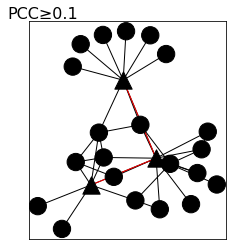

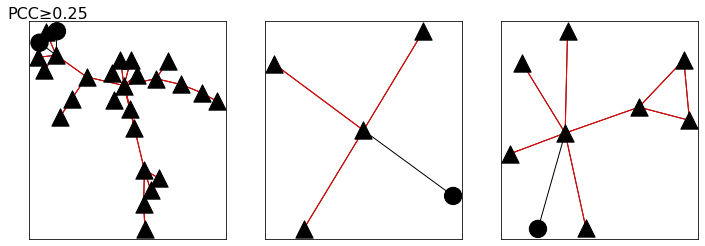

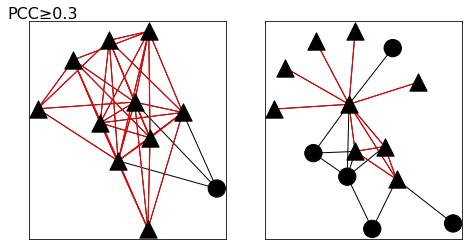

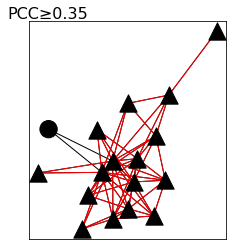

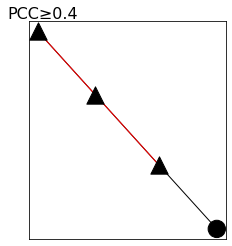

In [128]:
for key in thr_list:
    if key == 0.2 : 
        continue
    
    e_pcc = e_dict[key]
    sensors_pcc = sensor_dfs[key]
    e_pcc.df['is_sensor'] = e_pcc.df.orf_name.isin(sensors_pcc.orf_name)
    e_pcc.df.loc[:,['orf_name','is_sensor']].to_csv(f'../data/interim/thr_edgelist/{key}_df.csv')
    clusters = sorted(sensors_pcc.dropna(subset=['sensor_cluster']).sensor_cluster.unique())
    fig = plt.figure(figsize=(12,4))
    for itr, i in enumerate(clusters):
        ax_ = plt.subplot(1,3,itr+1)
        sub_orfs = sensors_pcc.loc[sensors_pcc.sensor_cluster==i,'orf_name'].tolist()
        sub_nw = get_subnetwork(e_pcc.graph_gc, sub_orfs, radius= 1)
        pos_sub = nx.spring_layout(sub_nw)
        nx.write_edgelist(sub_nw, f'../data/interim/thr_edgelist/{key}_{itr}.csv',delimiter=',')

        nx.draw_networkx_nodes(sub_nw,ax=ax_, pos = pos_sub, node_color = ['none' if i in sub_orfs else 'k' for i in sub_nw.nodes ])
        nx.draw_networkx_nodes(nx.induced_subgraph(sub_nw, sub_orfs), pos=pos_sub, node_shape='^', node_color='black')
        nx.draw_networkx_edges(sub_nw,ax=ax_, pos = pos_sub)
        nx.draw_networkx_edges(nx.induced_subgraph(sub_nw, sub_orfs), pos=pos_sub, edge_color='red')
        
#        ax.set_title("saga")
    fig.suptitle(f"PCC≥{key}",ha='left', x=0.1, y=0.93, fontsize=16)
    fig.savefig(f'../reports/figures/paper_figures_supp/{key}_sensor_antenna.png',dpi= 150, bbox_inches='tight')

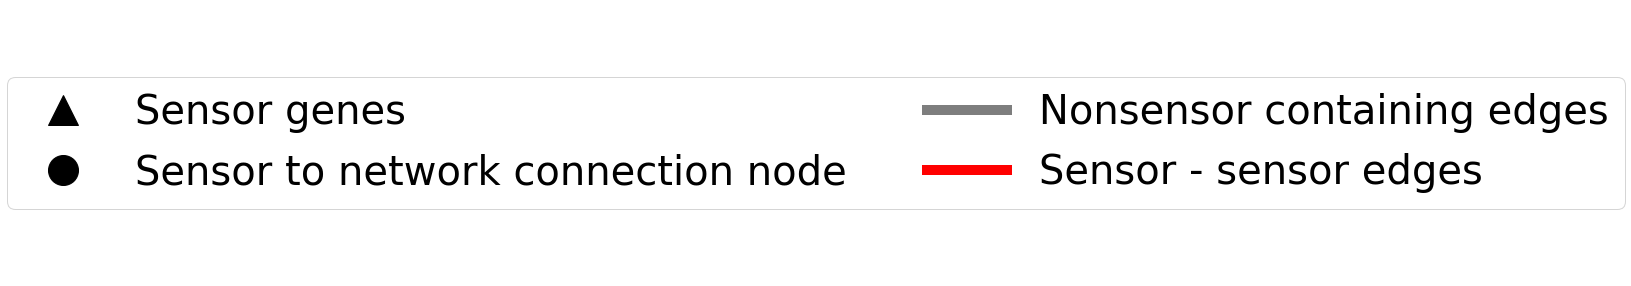

<Figure size 216x72 with 0 Axes>

In [113]:
from matplotlib.lines import Line2D
antenna_legend = []
antenna_legend.extend(
    [Line2D([0], [0], marker='^', color='black', label='Sensor genes',
                              markerfacecolor='black', markersize=30, linestyle="None"),
        Line2D([0], [0], marker='o', color='black', label='Sensor to network connection node',
                              markerfacecolor='black', markersize=30, linestyle="None"),
#                    Line2D([0], [0], marker='o', color='black', label='Effectors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
#                    Line2D([0], [0], marker='^', color='black', label='Sensors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
                       Line2D([0], [0], marker='o', color='black', label= 'Nonsensor containing edges',
                              markerfacecolor='black', markersize=0, linestyle="-", alpha=0.5, lw=10),
    Line2D([0], [0], marker='o', color='red', label= 'Sensor - sensor edges',
                              markerfacecolor='#018571', markersize=0, linestyle="-",lw=10)]
)
fig = plt.figure()
figlegend = plt.figure(figsize=(3,1))
ax = fig.add_subplot(111)
#lines = ax.plot(range(10), plt.randn(10), range(10), plt.randn(10))
ax.axis('off')
lgd = ax.legend(handles=antenna_legend, fontsize=40, loc='center',ncol=2)

fig.savefig(f'../reports/figures/paper_figures_supp/figs5_legend.png',bbox_inches='tight',dpi=150)